In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8

Using TensorFlow backend.


In [2]:
transactions = pd.read_csv('data/transactions_small_1p_all_features.csv')

In [3]:
labels = transactions['Label']
ids = transactions['TRANSACTION_ID']
del transactions['Label']

In [4]:
print(len(transactions.columns))
transactions.columns

23


Index(['Unnamed: 0', 'TRANSACTION_ID', 'TRANSACTION_AMOUNT',
       'CUSTOMER_RISK_SCORE', 'ACCOUNT_BALANCE', 'Sanction',
       'TRANSACTION_TYPE_charge', 'TRANSACTION_TYPE_electronic transfer',
       'TRANSACTION_TYPE_paper transfer', 'TRANSACTION_TYPE_pos',
       'TRANSACTION_TYPE_withdrawal', 'TRANSACTION_SOURCE_ach credit',
       'TRANSACTION_SOURCE_ach debit', 'TRANSACTION_SOURCE_atm',
       'TRANSACTION_SOURCE_merchant location', 'TRANSACTION_SOURCE_online',
       'TRANSACTION_SOURCE_p2p', 'TRANSACTION_SOURCE_swift',
       'TRANSACTION_SOURCE_teller', 'CUSTOMER_TYPE_Business',
       'CUSTOMER_TYPE_Individual', 'ACCOUNT_TYPE_basic checkings account',
       'ACCOUNT_TYPE_interest checking account'],
      dtype='object')

In [5]:
del transactions['Unnamed: 0']
del transactions['TRANSACTION_ID']

# Autoencoder

In [24]:
input_layer = Input(shape=(21, ))
encoder = Dense(20, activation="tanh")(input_layer)
encoder = Dense(18, activation="tanh")(encoder)
encoder = Dense(16, activation="tanh")(encoder)
encoder = Dense(14, activation="tanh")(encoder)
encoder = Dense(12, activation="tanh")(encoder)
encoder = Dense(10, activation="tanh")(encoder)
encoder = Dense(8, activation="tanh")(encoder)
encoder = Dense(6, activation="tanh")(encoder)
encoder = Dense(4, activation="tanh")(encoder)
encoder = Dense(2, activation="relu")(encoder)

decoder = Dense(4, activation='tanh')(encoder)
decoder = Dense(6, activation='tanh')(decoder)
decoder = Dense(8, activation='tanh')(decoder)
decoder = Dense(10, activation='tanh')(decoder)
decoder = Dense(12, activation='tanh')(decoder)
decoder = Dense(14, activation='tanh')(decoder)
decoder = Dense(16, activation='tanh')(decoder)
decoder = Dense(18, activation='tanh')(decoder)
decoder = Dense(20, activation='tanh')(decoder)
decoder = Dense(21, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [25]:
from keras import optimizers
adam = optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.1)

autoencoder.compile(optimizer=adam, loss='mean_squared_error')

In [26]:
X_train = transactions.values

In [27]:
# run on gpu0
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [28]:
nb_epoch = 10
batch_size = 32
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Train on 121547 samples, validate on 30387 samples
Epoch 1/10
121547/121547 [==============================] - 15s - loss: 0.0883 - val_loss: 0.0829
Epoch 2/10
121547/121547 [==============================] - 14s - loss: 0.0825 - val_loss: 0.0819
Epoch 3/10
121547/121547 [==============================] - 14s - loss: 0.0817 - val_loss: 0.0813
Epoch 4/10
121547/121547 [==============================] - 14s - loss: 0.0812 - val_loss: 0.0808
Epoch 5/10
121547/121547 [==============================] - 14s - loss: 0.0808 - val_loss: 0.0804
Epoch 6/10
121547/121547 [==============================] - 14s - loss: 0.0804 - val_loss: 0.0801
Epoch 7/10
121547/121547 [==============================] - 14s - loss: 0.0800 - val_loss: 0.0797
Epoch 8/10
121547/121547 [==============================] - 14s - loss: 0.0797 - val_loss: 0.0794
Epoch 9/10
121547/121547 [==============================] - 14s - loss: 0.0794 - val_loss: 0.0792
Epoch 10/10
121547/121547 [==============================] - 14s - 

# Prediction and Confusion Matrix

In [29]:
predictions = autoencoder.predict(X_train)
mse = np.mean(np.power(X_train - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': labels})
error_df.describe()

,reconstruction_error,true_class
count,151934.000000,151934.000000
mean,0.079027,0.000388
std,0.053131,0.019702
min,0.007499,0.000000
25%,0.051555,0.000000
50%,0.074622,0.000000
75%,0.110927,0.000000
max,0.255372,1.000000


In [30]:
threshold = 0.1

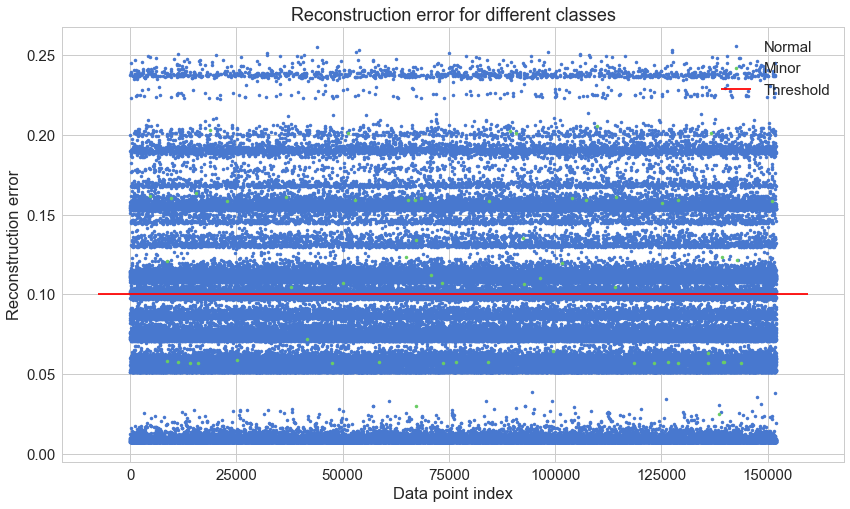

In [31]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Minor" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [32]:
threshold = 0.047

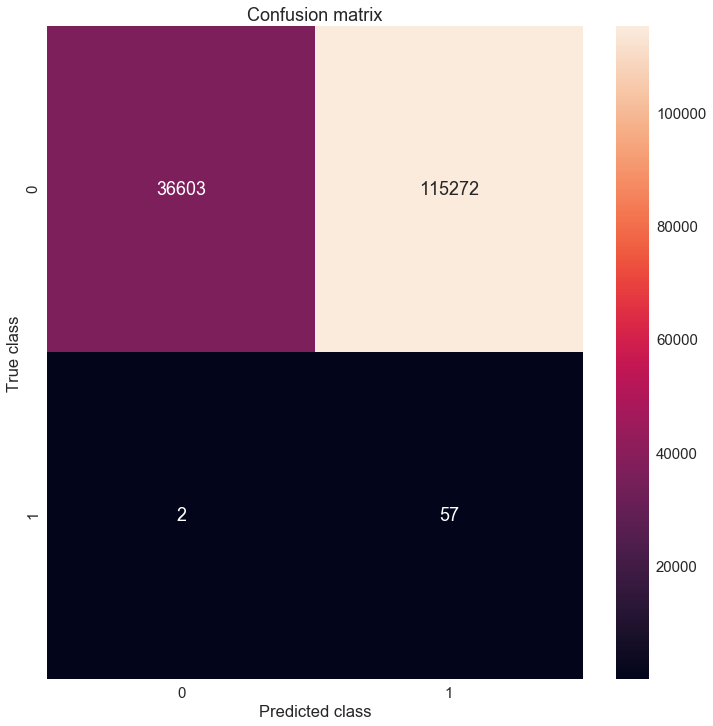

In [33]:
from sklearn.metrics import confusion_matrix
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=[0, 1], yticklabels=[0, 1], annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

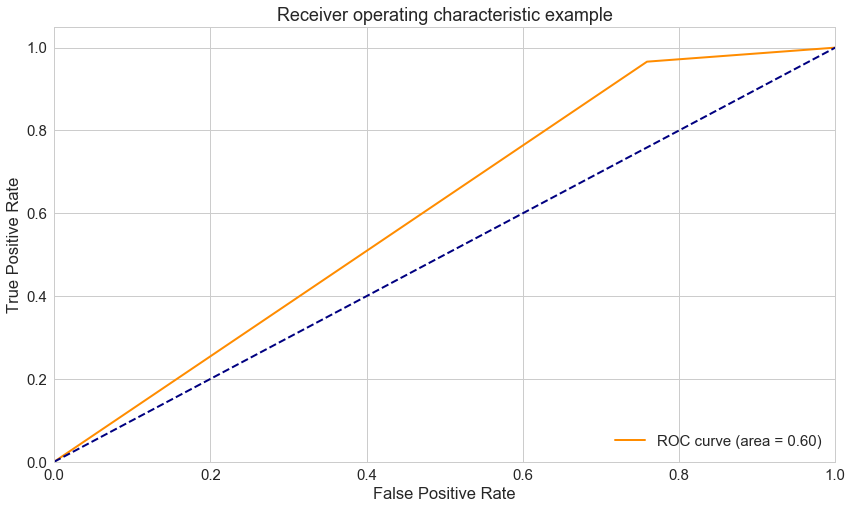

In [34]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(labels, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [35]:
small_data = transactions[pd.Series(y_pred) == 1]

In [36]:
small_labels = labels[pd.Series(y_pred) == 1]

In [37]:
small_ids = ids[pd.Series(y_pred) == 1]

In [38]:
input_layer = Input(shape=(21, ))
encoder = Dense(16, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(12, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(encoder)
encoder = Dense(8, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(encoder)
encoder = Dense(4, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(encoder)
#encoder = Dense(7, activation="tanh", 
#                activity_regularizer=regularizers.l1(10e-5))(encoder)
#encoder = Dense(6, activation="tanh", 
#                activity_regularizer=regularizers.l1(10e-5))(encoder)
#encoder = Dense(3, activation="tanh", 
#                activity_regularizer=regularizers.l1(10e-5))(encoder)
encoder = Dense(2, activation="relu")(encoder)

decoder = Dense(4, activation='tanh')(encoder)
decoder = Dense(8, activation='tanh')(decoder)
decoder = Dense(12, activation='tanh')(decoder)
decoder = Dense(16, activation='tanh')(decoder)
decoder = Dense(21, activation='tanh')(decoder)
#decoder = Dense(8, activation='tanh')(decoder)
#decoder = Dense(9, activation='relu')(decoder)

autoencoder_small = Model(inputs=input_layer, outputs=decoder)

In [39]:
from keras import optimizers
adam = optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

autoencoder.compile(optimizer=adam, loss='mean_squared_error')

In [40]:
small_train = small_data.values

In [41]:
nb_epoch = 1
batch_size = 16
checkpointer = ModelCheckpoint(filepath="model_small.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(small_train, small_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Train on 92263 samples, validate on 23066 samples
Epoch 1/1
92263/92263 [==============================] - 22s - loss: 0.0543 - val_loss: 0.0500


In [42]:
predictions_small = autoencoder_small.predict(small_train)
mse = np.mean(np.power(small_train - predictions_small, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': small_labels})
error_df.describe()

,reconstruction_error,true_class
count,115329.000000,115329.000000
mean,0.237794,0.000494
std,0.012834,0.022226
min,0.191427,0.000000
25%,0.229304,0.000000
50%,0.237148,0.000000
75%,0.245973,0.000000
max,0.316167,1.000000


In [43]:
threshold = 0.3

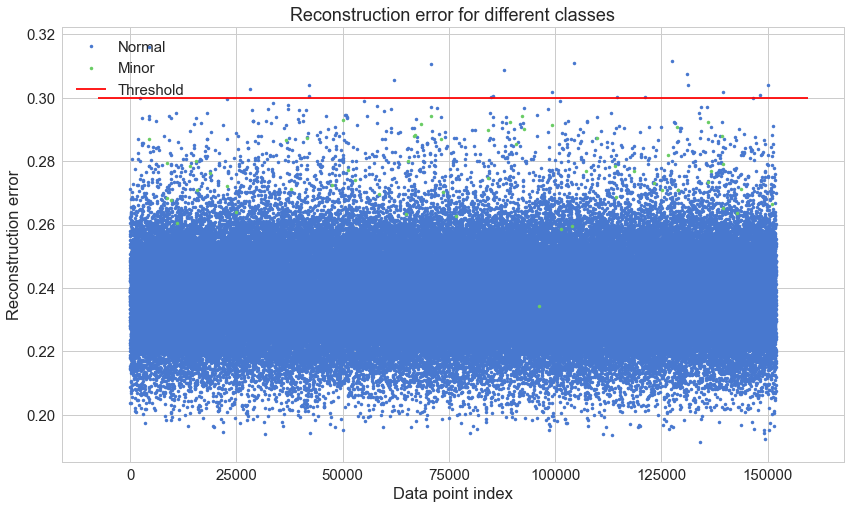

In [44]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Minor" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [45]:
threshold = 0.26

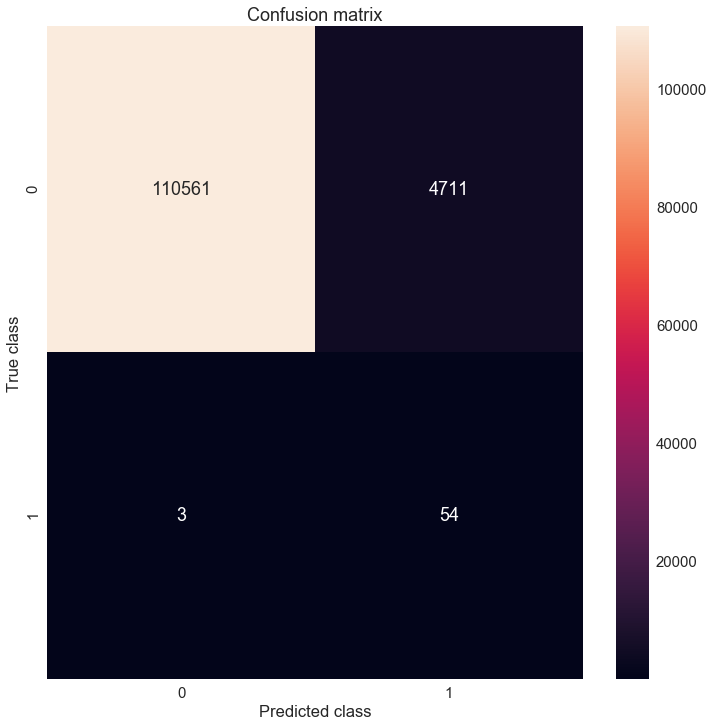

In [46]:
from sklearn.metrics import confusion_matrix
y_pred_small = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred_small)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=[0, 1], yticklabels=[0, 1], annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

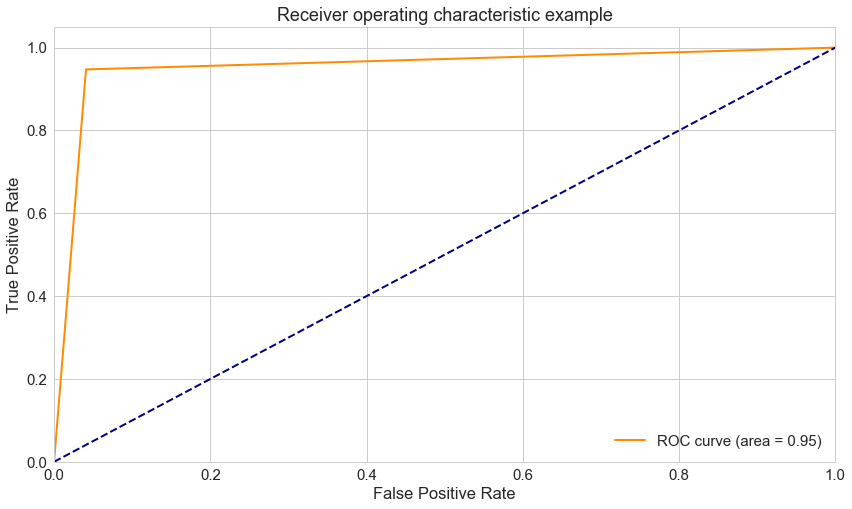

In [47]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(small_labels, y_pred_small)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()